In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import datetime
import os
import conda
import random
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import preprocessing
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl


%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(16,9)})

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

## Data Preparation

In [2]:
# Import data
customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
translation = pd.read_csv("product_category_name_translation.csv")

In [3]:
# Show data summary

datasets = [customers, geolocation, items, payments, orders, products, translation]
titles = ["customers", "geolocation", "items", "payments", "orders", "products", "translation"]

info_df = pd.DataFrame({},)
info_df['dataset']= titles
info_df['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]
info_df['cols_no']= [df.shape[1] for df in datasets]
info_df['null_no']= [df.isnull().sum().sum() for df in datasets]
info_df['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
info_df['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


info_df.style.background_gradient(cmap='coolwarm')

,dataset,cols,cols_no,null_no,null_cols_no,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",5,0,0,
1,geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",5,0,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",5,0,0,
4,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
5,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
6,translation,"product_category_name, product_category_name_english",2,0,0,


In [4]:
# Merge data together for further data manipulation efficiently
df = pd.merge(orders,items, on="order_id")
df = df.merge(customers, on="customer_id")
df = df.merge(payments, on="order_id")
df = df.merge(products, on="product_id")
df = df.merge(translation, on="product_category_name")

In [5]:
# Keep the DataFrame with valid entries in the same variable
df.dropna(inplace=True)

# Drop irrelevant colmuns
df = df.drop(['seller_id', 'product_category_name', 
              'product_name_lenght', 'product_description_lenght', 
              'product_photos_qty', 'product_weight_g', 'product_length_cm',
              'product_height_cm', 'product_width_cm'], axis=1)

df.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113367 entries, 0 to 115877
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113367 non-null  object 
 1   customer_id                    113367 non-null  object 
 2   order_status                   113367 non-null  object 
 3   order_purchase_timestamp       113367 non-null  object 
 4   order_approved_at              113367 non-null  object 
 5   order_delivered_carrier_date   113367 non-null  object 
 6   order_delivered_customer_date  113367 non-null  object 
 7   order_estimated_delivery_date  113367 non-null  object 
 8   order_item_id                  113367 non-null  int64  
 9   product_id                     113367 non-null  object 
 10  shipping_limit_date            113367 non-null  object 
 11  price                          113367 non-null  float64
 12  freight_value                 

In [6]:
# Convert datetime features to the correct format
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"], format='%Y-%m-%d %H:%M:%S')
df["order_approved_at"] = pd.to_datetime(df["order_approved_at"], format='%Y-%m-%d %H:%M:%S')
df["order_delivered_carrier_date"] = pd.to_datetime(df["order_delivered_carrier_date"], format='%Y-%m-%d %H:%M:%S')
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"], format='%Y-%m-%d %H:%M:%S')
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"], format='%Y-%m-%d %H:%M:%S')

In [7]:
# Create time series
time_series = df
time_series['order_purchase_year'] = time_series.order_purchase_timestamp.apply(lambda x: x.year)
time_series['order_purchase_month'] = time_series.order_purchase_timestamp.apply(lambda x: x.month)
time_series['month_year'] = time_series['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
time_series['month_year'] = time_series['order_purchase_year'].astype(str) + '-' + df['month_year'].astype(str)
time_series['month_y'] = time_series['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)
time_series['difference'] = time_series['price'] - time_series['payment_value']
time_series["discount"] = time_series["difference"]/time_series["price"]

In [8]:
# Define visualizaition functions
def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
def count_plot(feature, df, colors='Blues_d', hue=False, ax=None, title=''):
    
    # Preparing variables
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)
        
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    # Final configuration
    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):
    
    # Preparing variables
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    #fig, ax = plt.subplots()
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)
    # Setting borders
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()

## Sales Trend

Text(0, 0.5, 'Count')

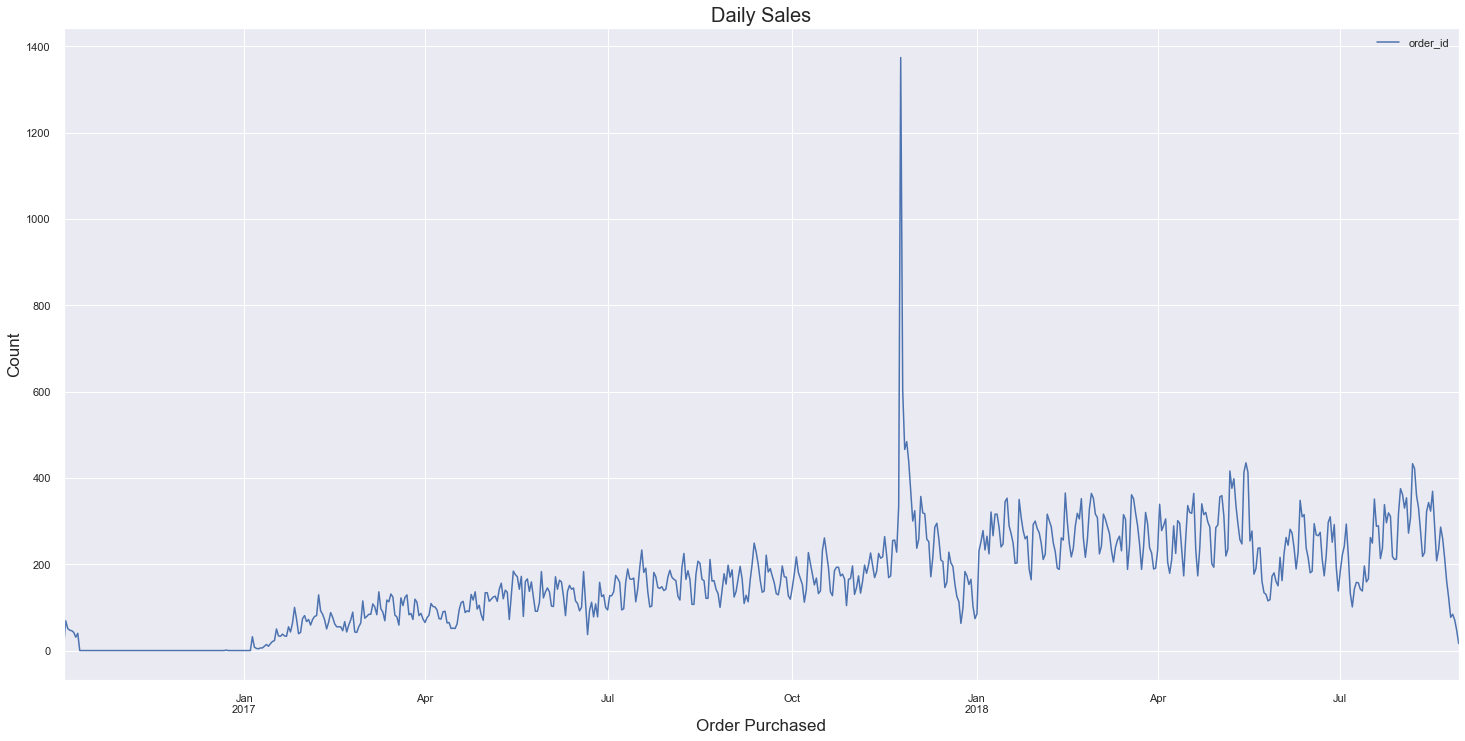

In [9]:
counts = time_series.set_index("order_purchase_timestamp").groupby(pd.Grouper(freq='D')).count()
fig = plt.figure(figsize=(25,12))
ax = fig.gca()
counts.plot(y = "order_id", use_index=True, ax=ax)
plt.title('Daily Sales',fontsize=20)
plt.xlabel('Order Purchased',fontsize=17)
plt.ylabel('Count',fontsize=17)

## Monthly Active Customers

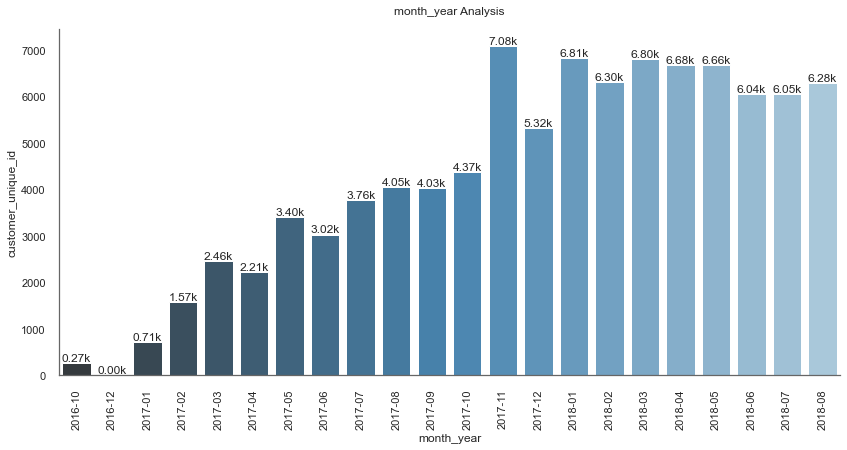

In [10]:
df_monthly_active = time_series.groupby('month_year')['customer_unique_id'].nunique().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='customer_unique_id', df=df_monthly_active, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

## Monthly Order Count

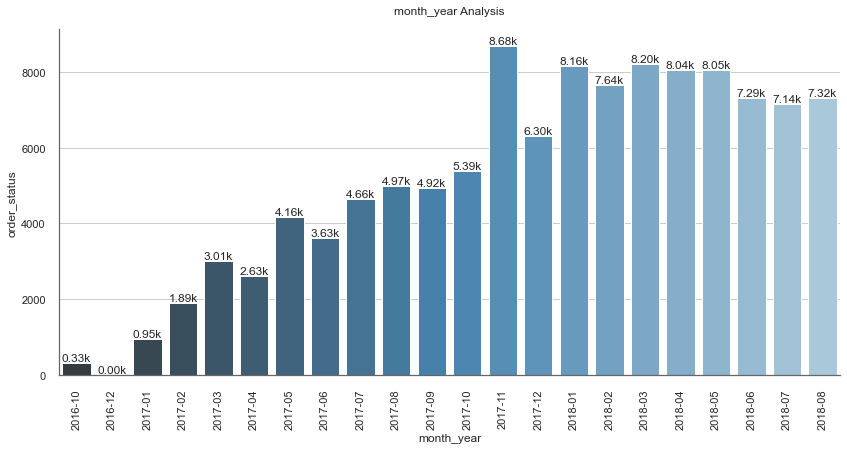

In [11]:
df_monthly_sales = time_series.groupby('month_year')['order_status'].count().reset_index()
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='order_status', df=df_monthly_sales, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

## Monthly Aggregate Payment Value

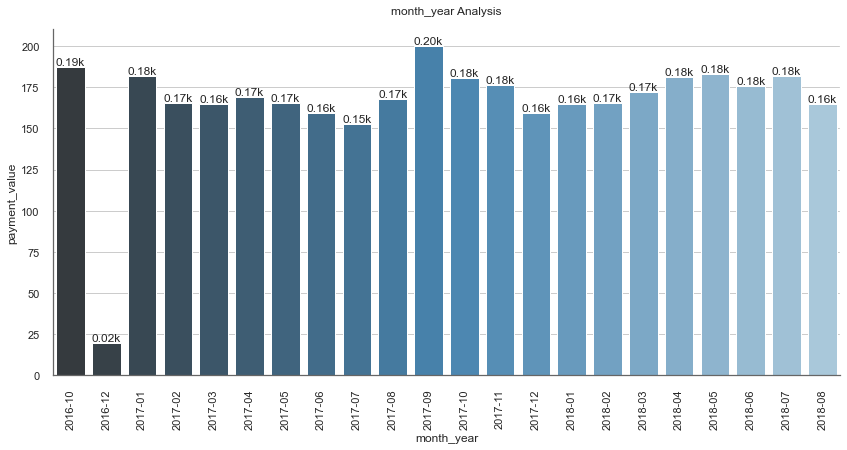

In [12]:
df_monthly_order_avg = time_series.groupby('month_year')['payment_value'].mean().reset_index()
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='payment_value', df=df_monthly_order_avg, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

## Monthly Aggregate Price

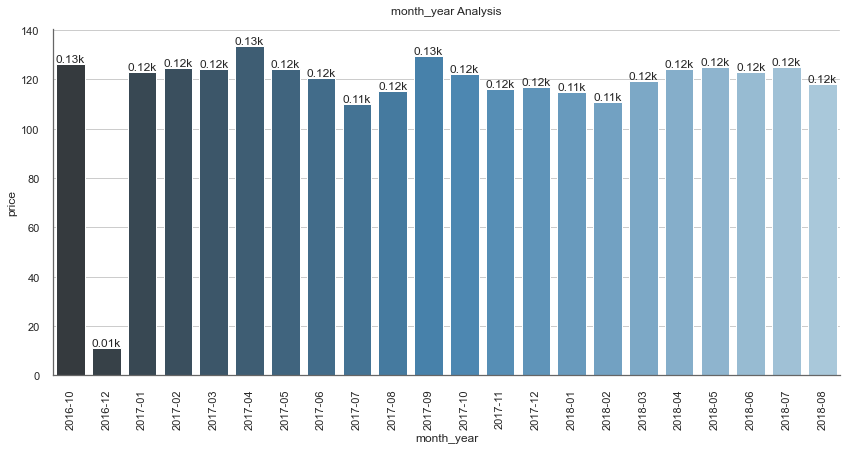

In [13]:
df_monthly_order_avg = time_series.groupby('month_year')['price'].mean().reset_index()
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
bar_plot(x='month_year', y='price', df=df_monthly_order_avg, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

## Price Time Series

Text(0.5, 1.0, 'Listing Price')

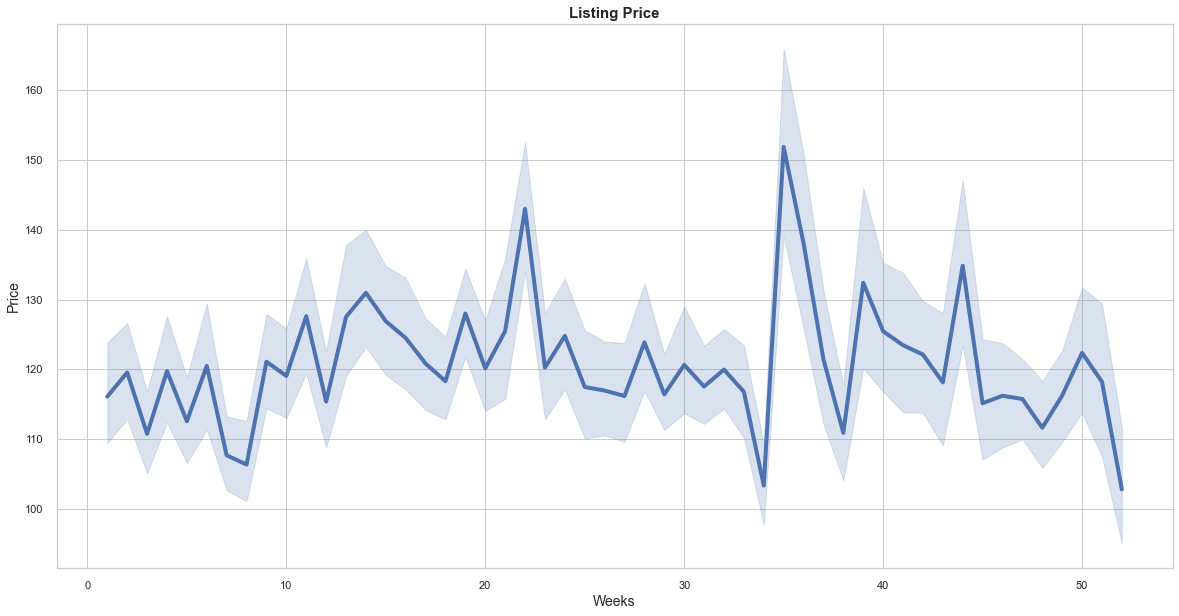

In [14]:
price_payment = df[["order_id", "order_delivered_customer_date", "order_purchase_timestamp", "order_status", "price","payment_value", "order_item_id"]]
price_payment['weekly']=pd.to_datetime(price_payment['order_purchase_timestamp'],format='%Y-%m-%d').dt.week
plt.figure(figsize=(20,10))
sns.set(style='whitegrid')
sns.lineplot(x='weekly', y='price', data=price_payment, linewidth=4,markers=True,dashes=False, estimator='mean')
plt.xlabel("Weeks", size=14)
plt.ylabel("Price", size=14)
plt.title("Listing Price",size=15, weight='bold')

## Transaction Time Series

Text(0.5, 1.0, 'Transaction Value')

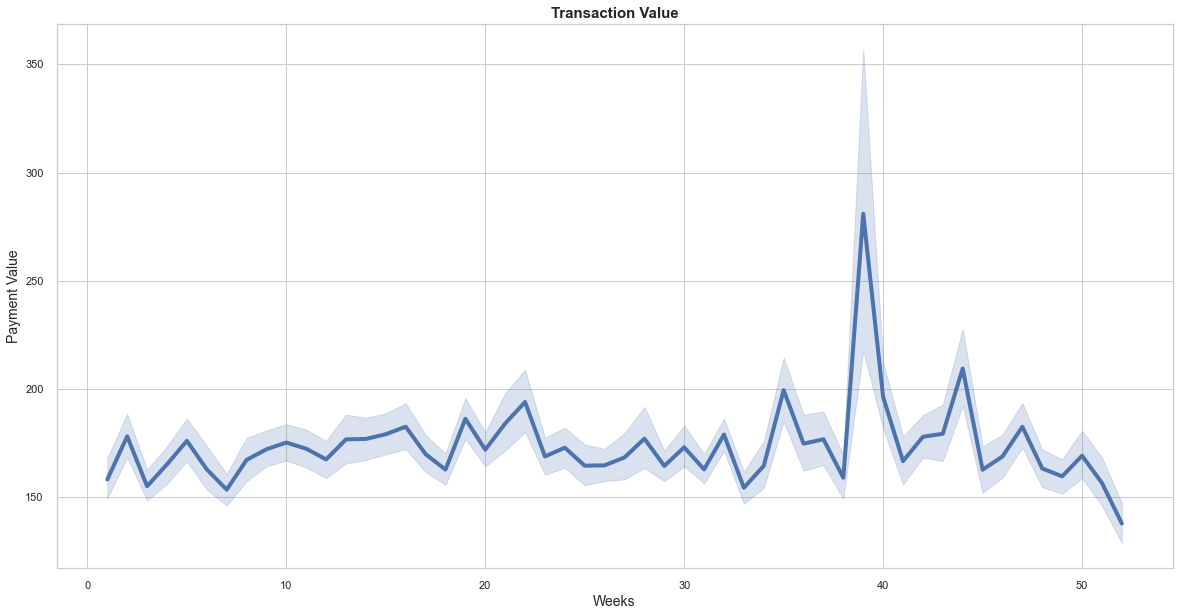

In [15]:
price_payment['weekly']=pd.to_datetime(price_payment['order_purchase_timestamp'],format='%Y-%m-%d').dt.week
plt.figure(figsize=(20,10))
sns.set(style='whitegrid')
sns.lineplot(x='weekly', y='payment_value', data=price_payment, linewidth=4,markers=True,dashes=False, estimator='mean')
plt.xlabel("Weeks", size=14)
plt.ylabel("Payment Value", size=14)
plt.title("Transaction Value",size=15, weight='bold')

## RFM Analysis

In [16]:
# Set intial time
Data_Corte = datetime.datetime(2018,9,13)

K_df = pd.merge(customers, orders, on='customer_id')
K_df = pd.merge(K_df, payments, on='order_id')
K_df['order_approved_at2'] = pd.to_datetime(K_df['order_approved_at'])
df1 = K_df.dropna(axis=0)
df1['order_approved_at3'] = df1['order_approved_at2']
df1 = df1.groupby('customer_unique_id').agg({'order_approved_at2': lambda x: (Data_Corte - x.max()).days,\
                                                    'order_id': lambda x: len(x), 'payment_value': lambda x: x.sum(),\
                                                    'order_approved_at3': lambda x: (Data_Corte - x.min()).days})

In [17]:
# Create a RFM table

df1['order_approved_at2'] = df1['order_approved_at2'].astype(int)
df1['order_approved_at3'] = df1['order_approved_at3'].astype(int)

df1.rename(columns={'order_approved_at2': 'Recency', 
                    'order_id': 'Frequency', 
                    'payment_value': 'Monetary_Value',
                    'order_approved_at3': 'Client_Since'}, inplace=True)

df1.describe()

,Recency,Frequency,Monetary_Value,Client_Since
count,93341.000000,93341.000000,93341.000000,93341.000000
mean,250.946604,1.079258,165.197318,253.588487
std,152.584562,0.449146,226.329624,153.091348
min,14.000000,1.000000,9.590000,14.000000
25%,127.000000,1.000000,63.050000,130.000000
50%,232.000000,1.000000,107.780000,235.000000
75%,359.000000,1.000000,182.540000,364.000000
max,708.000000,33.000000,13664.080000,708.000000


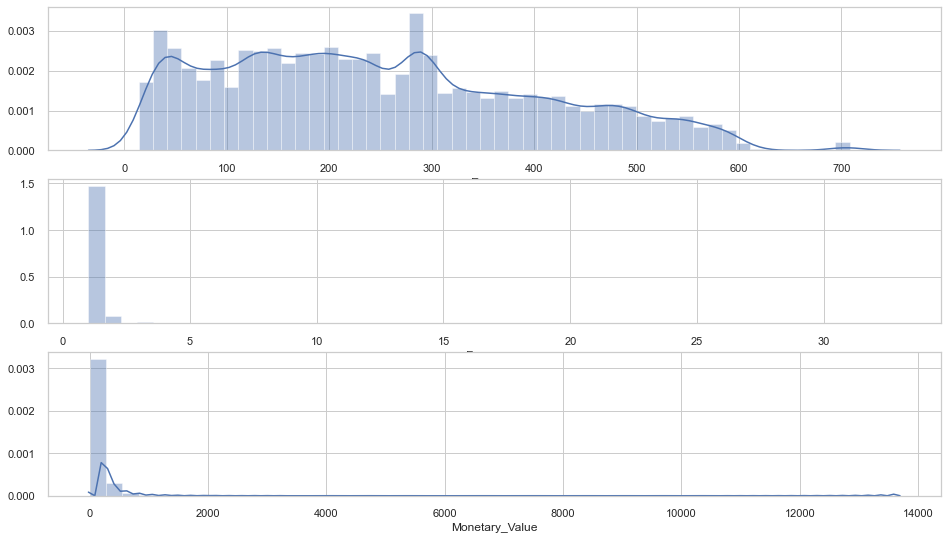

In [18]:
# Plot RFM distributions
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(df1['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df1['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df1['Monetary_Value'])
# Show the plot
plt.show()

# Calcualte Score for Every Sector

In [19]:
# Use the quintiles method, each quintiles contains 20% of the population. 
quintiles = df1[['Recency', 'Frequency', 'Monetary_Value']].quantile([.2, .4, .6, .8]).to_dict()

def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5  
    
df1['R'] = df1['Recency'].apply(lambda x: r_score(x))
df1['F'] = df1['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
df1['M'] = df1['Monetary_Value'].apply(lambda x: fm_score(x, 'Monetary_Value'))

In [20]:
# Get total RFM scores

df1['RFM Score'] = df1['R'].map(str) + df1['F'].map(str) + df1['M'].map(str)

segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

df1['Segment'] = df1['R'].map(str) + df1['F'].map(str)
df1['Segment'] = df1['Segment'].replace(segt_map, regex=True)

RFM = df1.drop(["Segment"], axis=1, inplace= False)

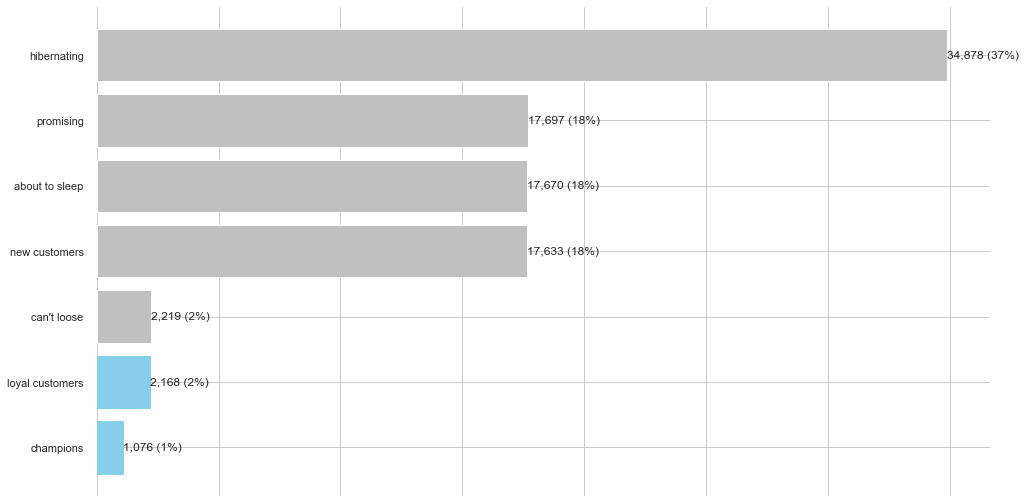

In [21]:
# Segementation based on RFM scores

segments_counts = df1['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('skyblue')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

## Executing K-means - 5 Segments

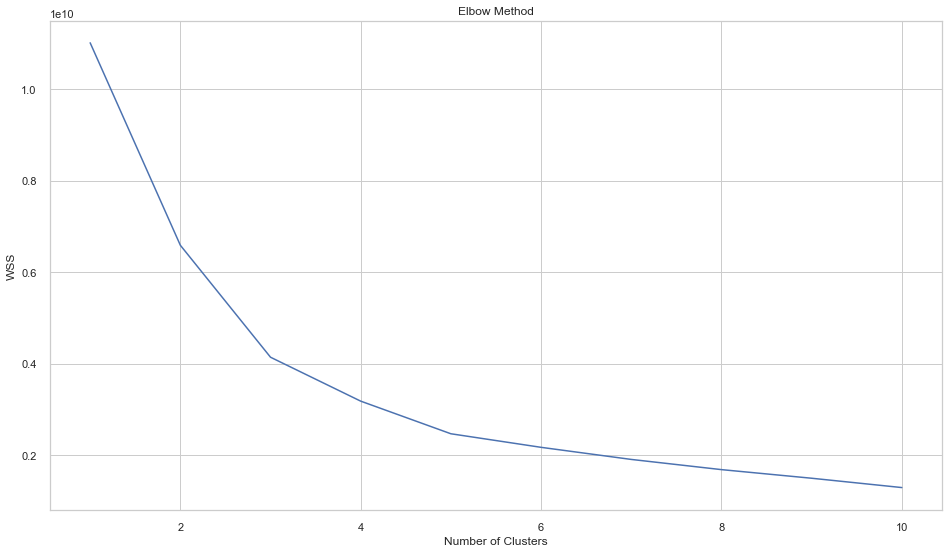

In [22]:
#Elbow method: Identify the optimal K
wcss = []
 
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(RFM)
    #print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)  
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

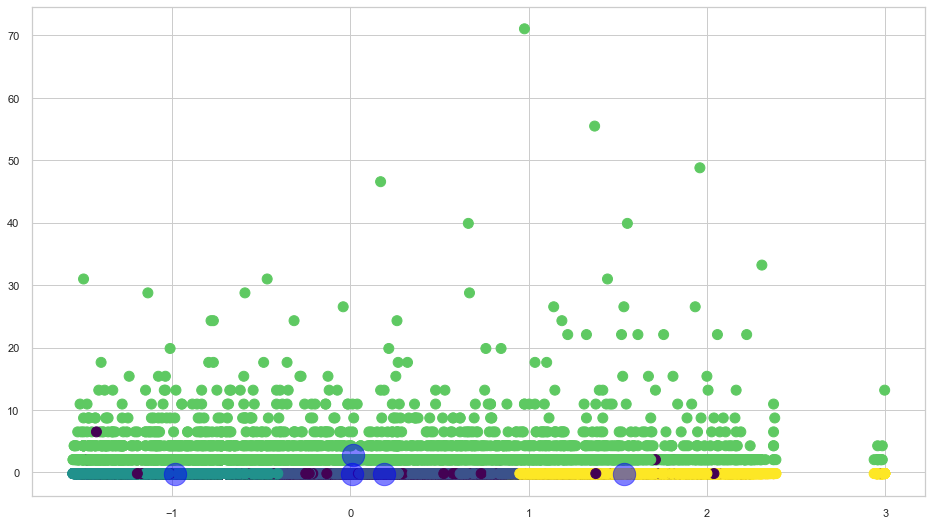

In [23]:
# Variables normalized
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(RFM) 

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(scaled_df)
kmeans.predict(scaled_df)

RFM['Cluster_ID'] = kmeans.predict(scaled_df)
freq = RFM.groupby(['Cluster_ID'])
freq = freq['Cluster_ID'].agg('count')

y_kmeans = kmeans.predict(scaled_df)
plt.scatter(scaled_df[:, 0], scaled_df[:, 1], c=y_kmeans, s=100, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='blue', s=500, alpha=0.5)

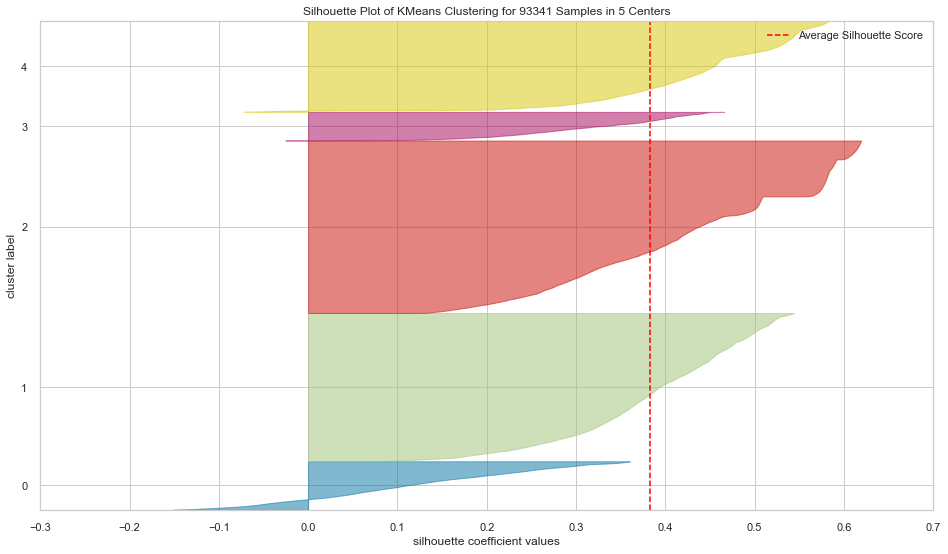

In [24]:
# Instantiate the clustering model and visualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(scaled_df) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

In [25]:
# Summarize
km_clusters_amount = pd.DataFrame(RFM.groupby(["Cluster_ID"]).Monetary_Value.mean())
km_clusters_frequency = pd.DataFrame(RFM.groupby(["Cluster_ID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM.groupby(["Cluster_ID"]).Recency.mean())

df2 = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df2.columns = ["Cluster_ID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df2.head()

,Cluster_ID,Amount_mean,Frequency_mean,Recency_mean
0,0,547.259992,1.001512,252.352414
1,1,94.658474,1.000000,279.895879
2,2,123.337092,1.000000,101.345017
3,3,232.335795,2.354614,253.097230
4,4,134.790756,1.000000,485.327151


## Plot Result of RFM

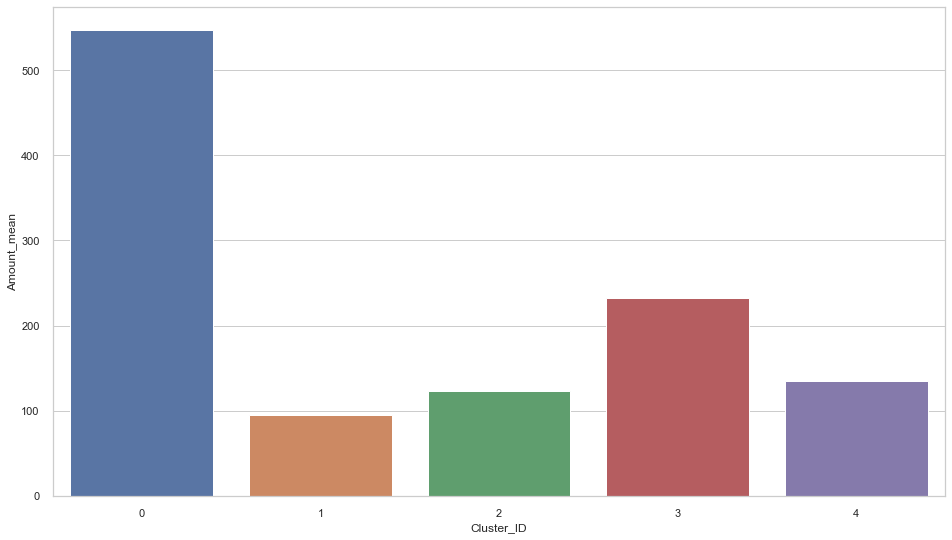

In [26]:
sns.barplot(x=df2.Cluster_ID, y=df2.Amount_mean)

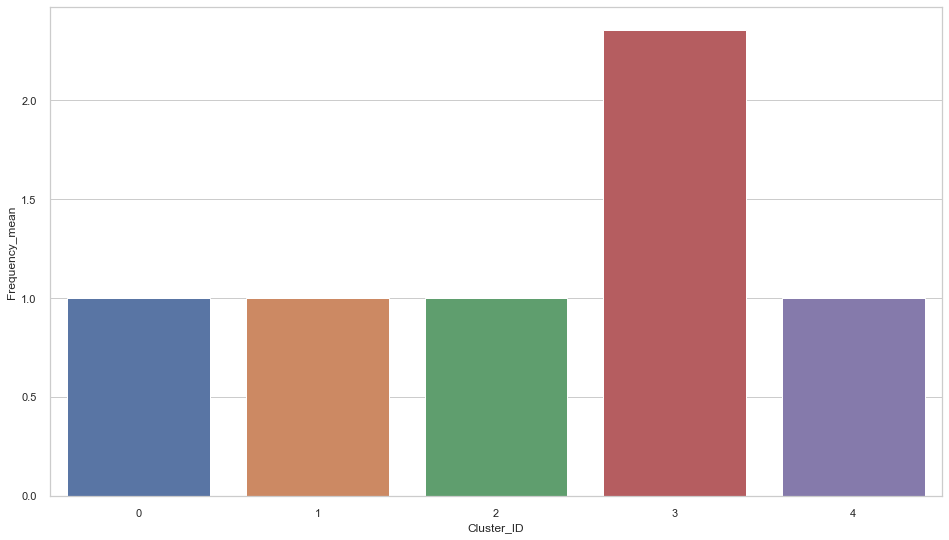

In [27]:
sns.barplot(x=df2.Cluster_ID, y=df2.Frequency_mean)

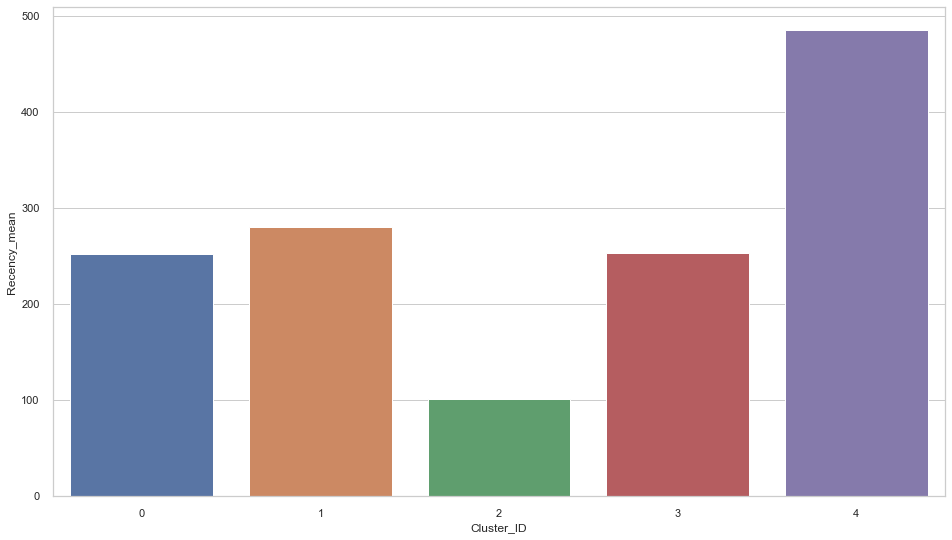

In [28]:
sns.barplot(x=df2.Cluster_ID, y=df2.Recency_mean)